<a href="https://colab.research.google.com/github/ivezic/Notebooks/blob/master/LSST_autoenc_ZI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install python-snappy
!pip install lsst-alert-packet

     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 1.4MB 11.7MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.alert.packet as ap 
import astropy
import io
import urllib.request
import itertools
import astropy.io.fits
import cv2

In [4]:
url=" https://lsst.ncsa.illinois.edu/~ebellm/sample_precursor_alerts/2020-07-15/DECam-HiTS/"
alertfile = 'single_visit_sample_DECam-HiTS_2020-07-15.avro'
urllib.request.urlretrieve(url+alertfile, filename='latest_single_visit_sample.avro')

('latest_single_visit_sample.avro',
 <http.client.HTTPMessage at 0x7efca60cf860>)

In [5]:
def fetch_data (alertfile='latest_single_visit_sample.avro', stamp_size=32, SNR_cond=1000):
  i=-1
  ID=np.array([])
  schema = ap.Schema.from_file()
  data=np.empty ([0,stamp_size,stamp_size,1], dtype=np.float32)
  with open (alertfile, "rb") as f:
    writer_schema, packet_iter = schema.retrieve_alerts(f)
    for packet in packet_iter:
      i+=1
      stamp=packet["cutoutDifference"]
      stats=packet["diaSource"]
      SNR=stats["totFlux"]/stats["totFluxErr"]
      if (SNR > SNR_cond) & (SNR <1030):
        with io.BytesIO(stamp) as img_file:
          img_data=astropy.io.fits.getdata(img_file, ext=0)
          if np.any(np.isnan(img_data)):
            continue
          ID=np.append(ID,i)
          img_data=(img_data-np.min(img_data))/(np.max(img_data)- np.min(img_data))
          img_data=cv2.resize(img_data,(stamp_size,stamp_size))
          img_data=np.expand_dims(img_data, axis=0)
          img_data=np.expand_dims(img_data, axis=3)
          data=np.append(data,img_data,axis=0)
  print (data.shape[0])
  return data, ID

def show_stamp_pic (data,ID):
  fig, ax = plt.subplots(data.shape[0],figsize=(100,100))
  for i, pic in enumerate (data):
    i=np.reshape(i,(i.shape[0],i.shape[1]))
    ax[i].axis('off')
    ax[i].imshow(pic, cmap='gray')
    ax[i].set_title("ID="+str(int(ID[i])))

In [6]:
data, ID=fetch_data(SNR_cond=10)

3063


AttributeError: ignored

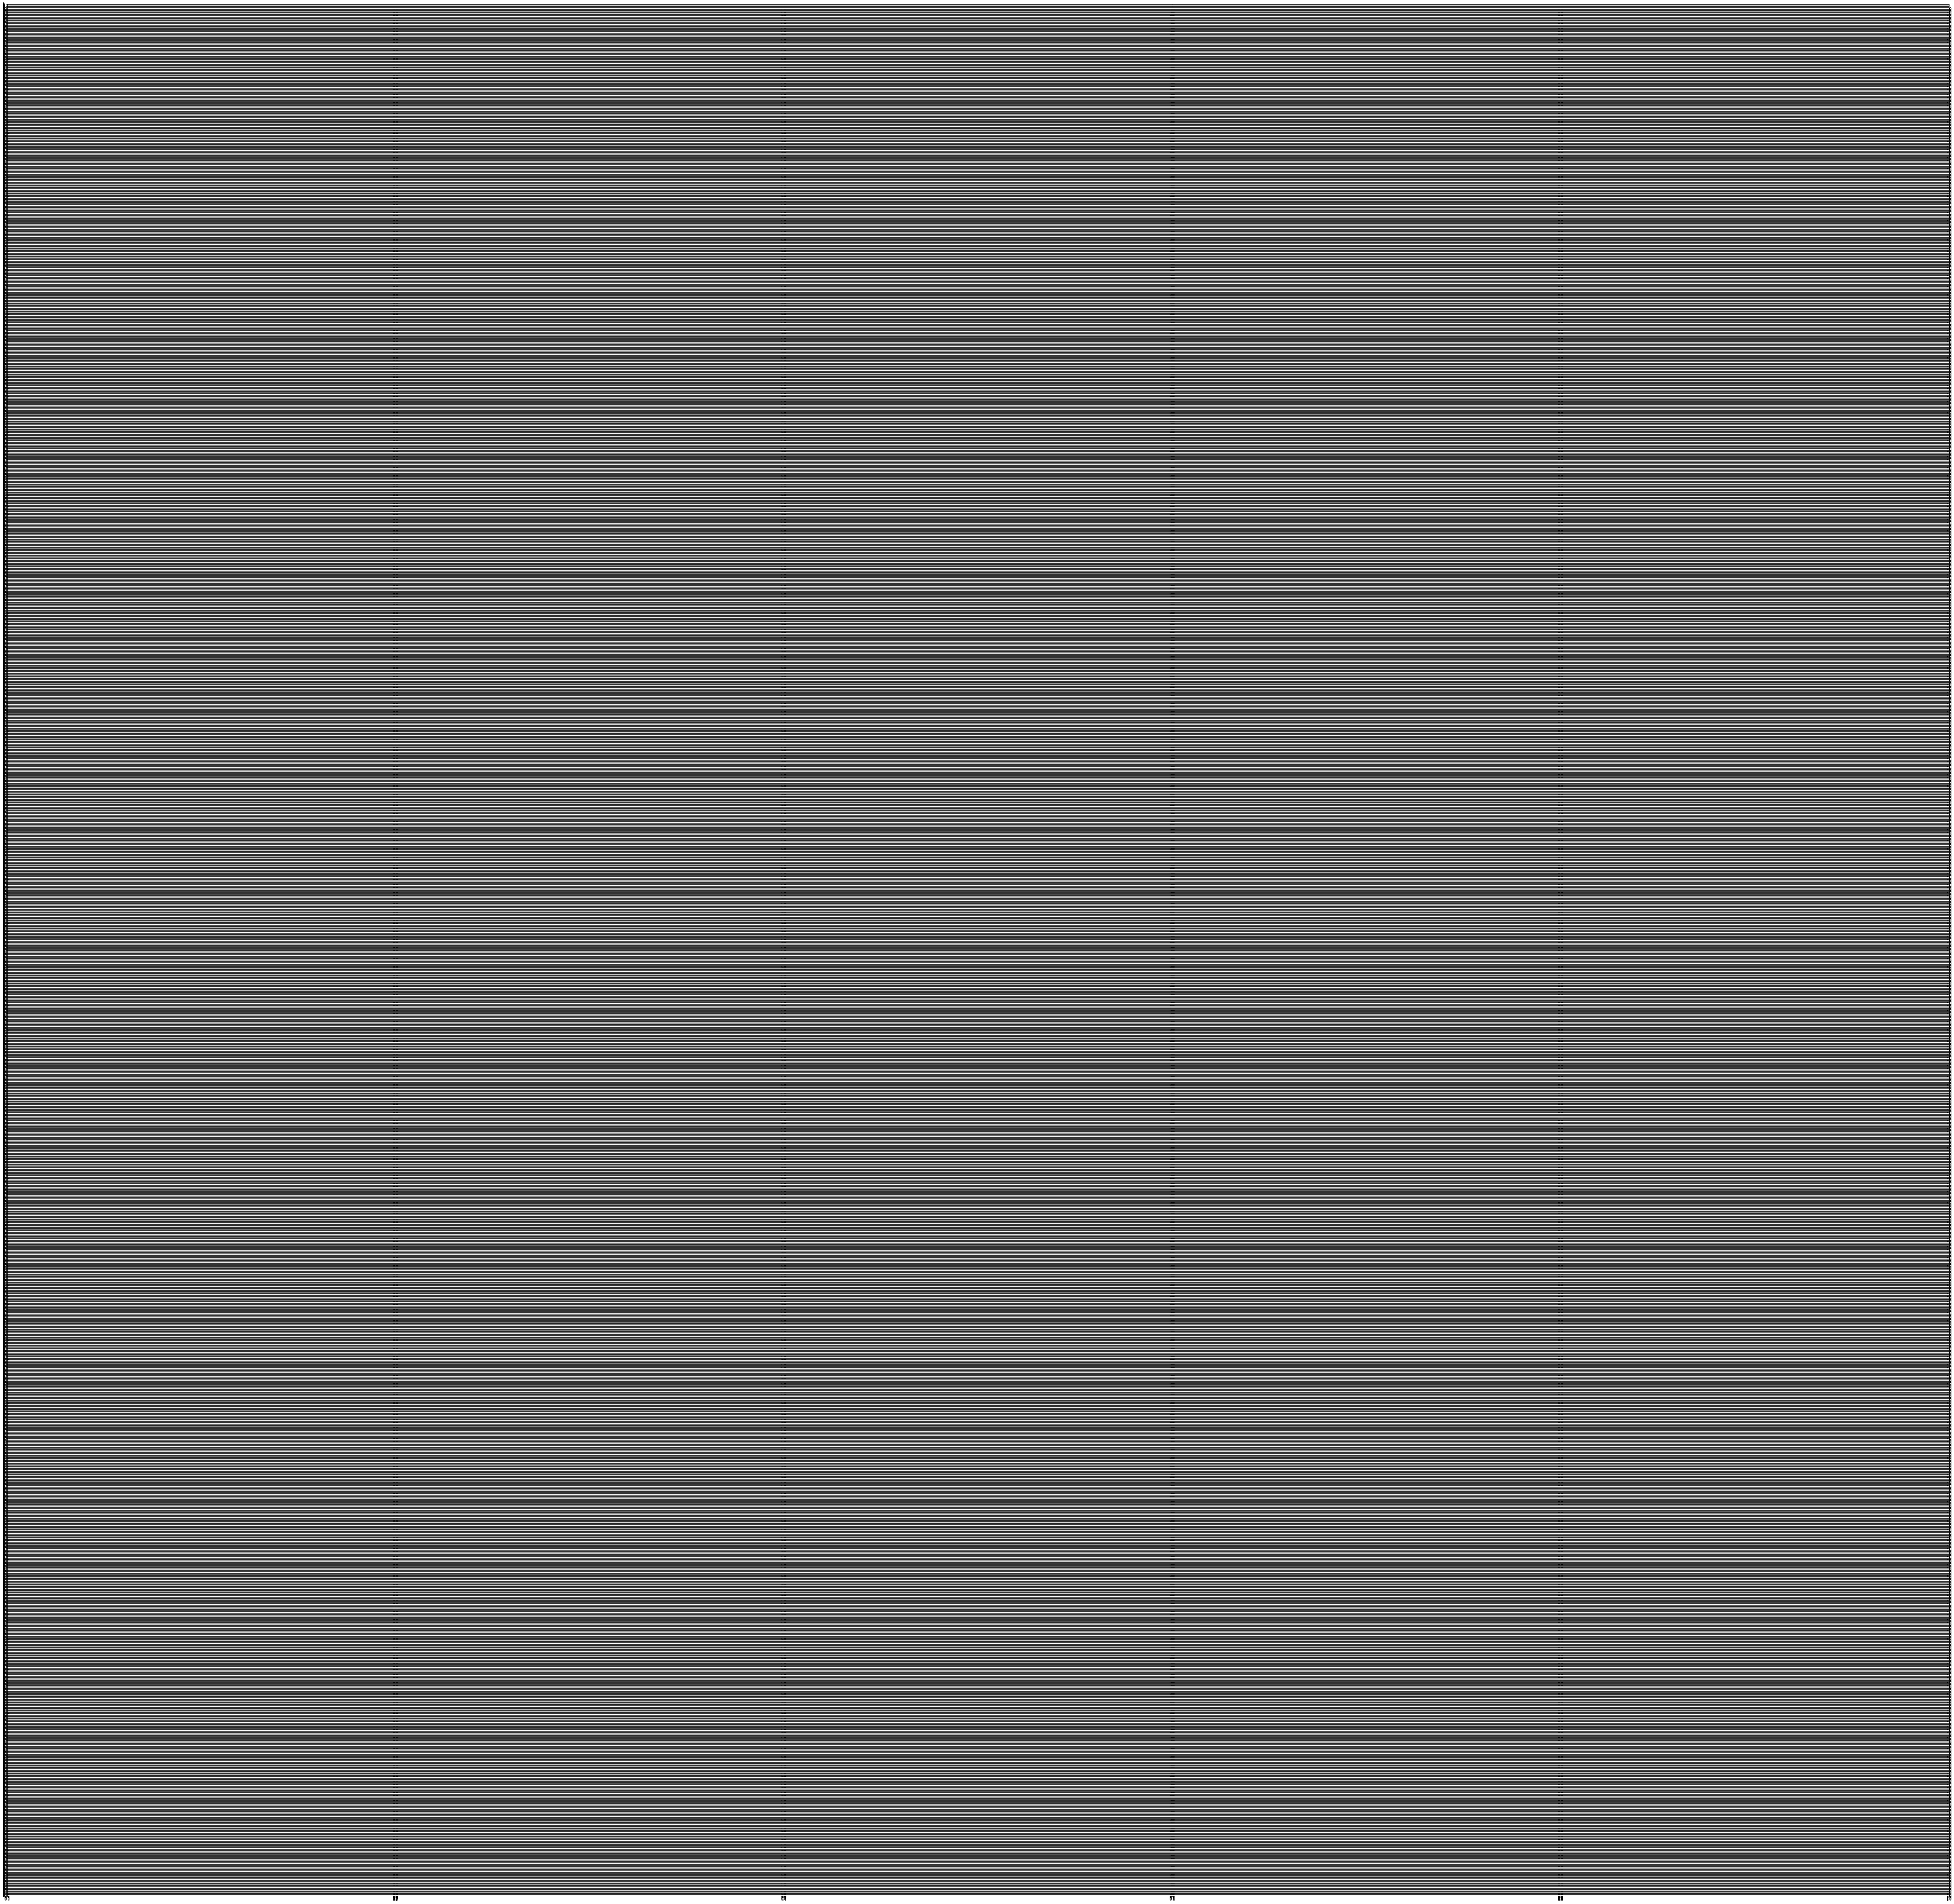

In [7]:
show_stamp_pic(data,ID)

In [8]:
import keras
filters=[16,32,64,128]
f=3
act="relu"
znum=100
model1 = keras.models.Sequential([
    keras.layers.Conv2D(filters[0], (f, f), activation=act, padding='same', input_shape=(32,32,1), name="econv1"),
    keras.layers.MaxPooling2D((2, 2), padding='same', name="epool1"),
    keras.layers.Conv2D(filters[1], (f, f), activation=act, padding='same', name="econv2"),
    keras.layers.MaxPooling2D((2, 2), padding='same',name="epool2"),
    keras.layers.Conv2D(filters[2], (f, f), activation=act, padding='same', name="econv3"),
    keras.layers.MaxPooling2D((2, 2), padding='same',name="epool3"),
    keras.layers.Conv2D(filters[3], (f, f), activation=act, padding='same', name="econv4"),
    keras.layers.Flatten(name="eflatten"),
    keras.layers.Dense(znum, activation='tanh', name="middle"),
    keras.layers.Dense(2048, activation='tanh', name="ddense1"),
    keras.layers.Reshape((4,4,128), name="dflatten"),
    keras.layers.Conv2DTranspose(filters[2], (f, f), activation=act, padding='same', name="dconv4"),    
    keras.layers.UpSampling2D((2, 2),name="dpool3"),
    keras.layers.Conv2DTranspose(filters[1], (f, f), activation=act, padding='same', name="dconv3"),  
    keras.layers.UpSampling2D((2, 2),name="dpool2"),
    keras.layers.Conv2DTranspose(filters[0], (f, f), activation=act, padding='same', name="dconv2"),
    keras.layers.UpSampling2D((2, 2),name="dpool1"),
    keras.layers.Conv2DTranspose(1, (f, f), activation="sigmoid", padding='same', name="dconv1")
])
model1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
#model1.summary()
#keras.utils.plot_model(model1, show_shapes=True)
#model1.get_layer("eflatten").input_shape [1:]

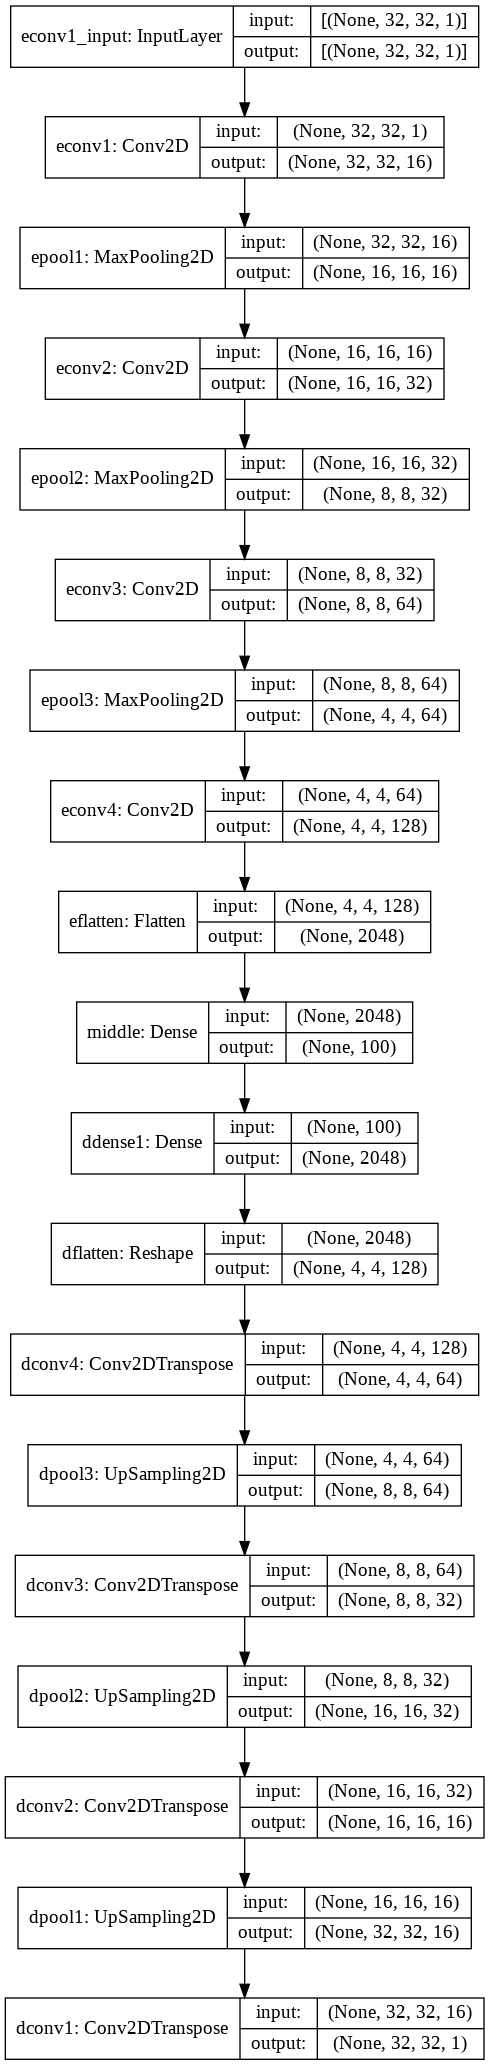

In [9]:
keras.utils.plot_model(model1, show_shapes=True)

In [10]:
a=model1.fit(data, data, batch_size=32, epochs=100)

Epoch 1/100
96/96 [==============================] - 9s 76ms/step - loss: 0.6812 - accuracy: 1.8067e-05
Epoch 2/100
96/96 [==============================] - 7s 77ms/step - loss: 0.6243 - accuracy: 1.6282e-05
Epoch 3/100
96/96 [==============================] - 8s 80ms/step - loss: 0.6209 - accuracy: 1.7289e-05
Epoch 4/100
96/96 [==============================] - 7s 77ms/step - loss: 0.6138 - accuracy: 2.2275e-05
Epoch 5/100
96/96 [==============================] - 7s 78ms/step - loss: 0.6132 - accuracy: 2.0738e-05
Epoch 6/100
96/96 [==============================] - 7s 77ms/step - loss: 0.6178 - accuracy: 1.8615e-05
Epoch 7/100
96/96 [==============================] - 7s 78ms/step - loss: 0.6171 - accuracy: 1.8320e-05
Epoch 8/100
96/96 [==============================] - 7s 78ms/step - loss: 0.6143 - accuracy: 1.7267e-05
Epoch 9/100
96/96 [==============================] - 8s 79ms/step - loss: 0.6149 - accuracy: 2.2895e-05
Epoch 10/100
96/96 [==============================] - 8s 79ms/st

In [11]:
a = model1.predict(data)

n: 90 -8.321271 0.19197991 0.21832429
n: 91 -80.368 0.6222856 0.44199175
n: 92 -8.483395 0.13813104 0.41107425
n: 93 10.747565 0.061083473 0.35593605
n: 94 4.35345 0.17388724 0.31337297
n: 95 -11.437496 0.3023741 0.43103302
n: 96 3.1717007 0.14646752 0.2932783
n: 97 -34.11377 0.62625945 0.59197736
n: 98 -38.35984 0.8047456 0.3033553
n: 99 1.9105971 0.16869573 0.4797174


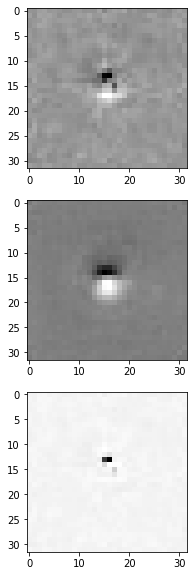

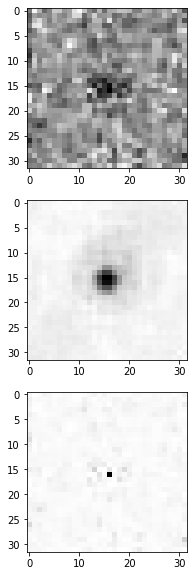

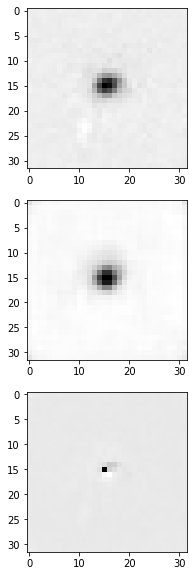

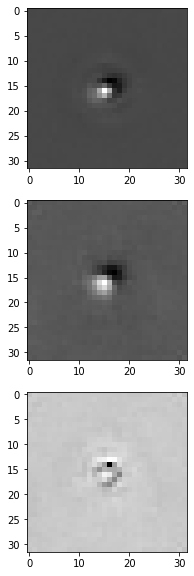

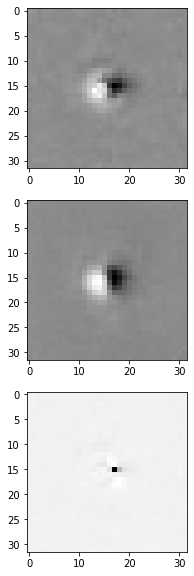

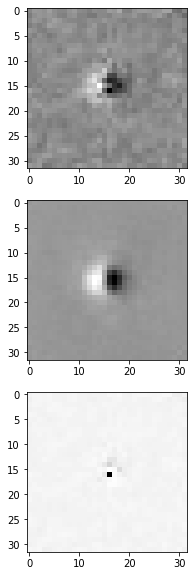

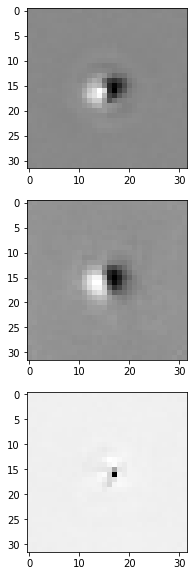

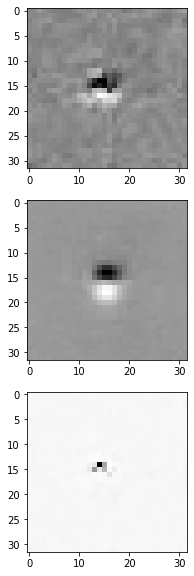

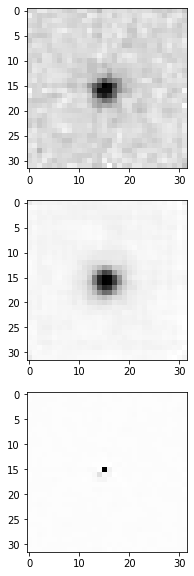

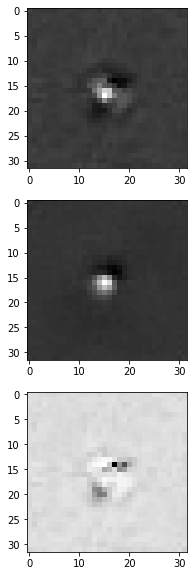

In [12]:
for n in range(90, 100):
  fig, ax = plt.subplots(3,figsize=(10,10))
  dataImage = np.resize(data[n],(32,32))
  modelImage = np.resize(a[n],(32,32))
  relResid = (dataImage-modelImage)/dataImage
  ax[0].imshow(dataImage, cmap='gray')
  ax[1].imshow(modelImage, cmap='gray')
  ax[2].imshow(relResid, cmap='gray')
  print('n:', n, np.sum(relResid), np.std(relResid), np.max(relResid))
  

In [13]:
for n in range(0, 100):
  dataImage = np.resize(data[n],(32,32))
  modelImage = np.resize(a[n],(32,32))
  relResid = (dataImage-modelImage)/dataImage
  print('n:', n, np.sum(relResid), np.std(relResid), np.max(relResid))
  

n: 0 4.004051 0.10691518 0.5601883
n: 1 -27.716862 0.25528786 0.5642091
n: 2 -44.124317 0.75054044 0.30001178
n: 3 2.0360122 0.10740422 0.38890547
n: 4 -9.866972 0.16693854 0.400301
n: 5 -16.57737 0.35197157 0.46780038
n: 6 -10.768833 0.18422736 0.55013627
n: 7 -61.32969 0.5962993 0.55848604
n: 8 4.8667116 0.062413175 0.38002473
n: 9 -4.8083396 0.11720798 0.43528736
n: 10 -116.33637 3.0083396 0.27345294
n: 11 -39.99939 0.68542236 0.3507938
n: 12 -19.951542 0.23641048 0.3923159
n: 13 -29.513458 0.23864704 0.444672
n: 14 -7.057782 0.1558809 0.32813314
n: 15 -53.925743 0.31633008 0.44172457
n: 16 -1.2152328 0.21720025 0.61787057
n: 17 -19.163494 0.5200615 0.3763956
n: 18 -40.286728 0.4604408 0.453179
n: 19 -9.828536 0.27908018 0.3307609
n: 20 -inf nan 0.4591334
n: 21 -6.1552444 0.21876074 0.28353783
n: 22 -9.333191 0.24974342 0.39869735
n: 23 -13.29017 0.29939604 0.6060102
n: 24 8.296999 0.27228883 0.5754855
n: 25 -19.445103 0.16867866 0.38172925
n: 26 -36.695312 0.29839015 0.4786585
n: 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [14]:
def show3(n):
  fig, ax = plt.subplots(3,figsize=(10,10))
  dataImage = np.resize(data[n],(32,32))
  modelImage = np.resize(a[n],(32,32))
  relResid = (dataImage-modelImage)/dataImage
  ax[0].imshow(dataImage, cmap='gray')
  ax[1].imshow(modelImage, cmap='gray')
  ax[2].imshow(relResid, cmap='gray')
  print('n:', n, np.sum(relResid), np.std(relResid), np.max(relResid))
  return

n: 20 -inf nan 0.4591334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


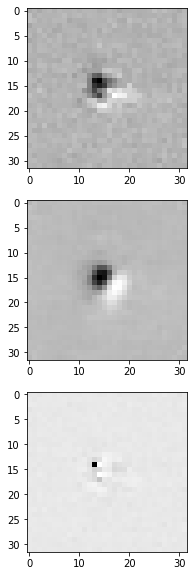

In [15]:
show3(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


n: 39 -inf nan 0.49626723


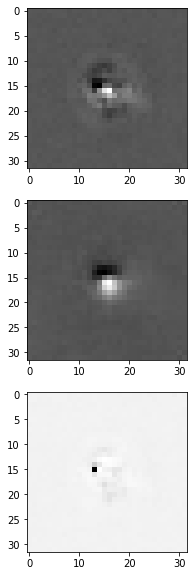

In [16]:
show3(39)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


n: 79 -inf nan 0.45130593


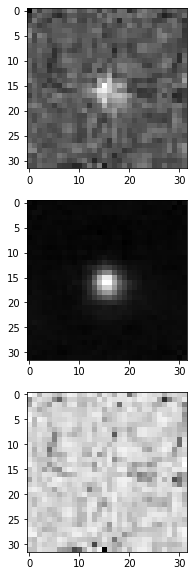

In [17]:
show3(79)

In [18]:
print('just test')

just test
